# Implementación en numpy

In [2]:
import os
import numpy as np
import pickle
import itertools
import pandas as pd
# Perceptron con python: https://pyimagesearch.com/2021/05/06/implementing-the-perceptron-neural-network-with-python/#pyis-cta-modal
# Perceptron con PyTorch: https://www.geeksforgeeks.org/what-is-perceptron-the-simplest-artificial-neural-network/
# Perceptrones multicapa con PyTorch: https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.ipynb
# Implementación Forward Propagation: https://www.geeksforgeeks.org/what-is-forward-propagation-in-neural-networks/
# Implementación Back Propagation: https://www.geeksforgeeks.org/backpropagation-in-neural-network/

In [3]:
# Imagenes a color RGB
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(data_dir='cifar-10-batches-py'):
    # Cargar datos de entrenamiento
    data = []
    labels = []
    for i in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])

    data = np.concatenate(data)
    labels = np.concatenate(labels)

    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    labels = np.eye(10)[labels]  # One-hot encoding

    # Cargar datos de prueba
    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    test_labels = np.eye(10)[test_batch[b'labels']]

    return data, labels, test_data, test_labels

def load_cifar100(data_dir='cifar-100-python'):
    data = unpickle(os.path.join(data_dir, 'train'))
    x_train = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    y_train = np.eye(100)[data[b'fine_labels']]

    data = unpickle(os.path.join(data_dir, 'test'))
    x_test = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0
    y_test = np.eye(100)[data[b'fine_labels']]

    return x_train, y_train, x_test, y_test

### Implementación

In [7]:
# --- FUNCIONES DE ACTIVACIÓN ---
def linear(x):
    return x
def linear_deriv(x):
    return np.ones_like(x)

class Perceptron:
    """
    Implementación de un perceptrón simple.
    Cada perceptrón tiene sus propios pesos y bias, y utiliza la función de activación sigmoide.
    """
    def __init__(self, input_size, learning_rate=0.1, activation='sigmoid'):
        # Inicialización de pesos y bias con valores pequeños aleatorios
        # Esto ayuda a romper la simetría y permite que cada neurona aprenda cosas distintas
        # self.weights = np.random.randn(input_size)
        # self.bias = np.random.randn()
        limit = np.sqrt(6 / (input_size + 1))
        self.weights = np.random.uniform(-limit, limit, input_size)
        self.bias = 0.0
        self.learning_rate = learning_rate
        self.activation_name = activation
        if activation == 'sigmoid':
            self.activation = lambda x: 1 / (1 + np.exp(-x))
            self.activation_derivative = lambda x: x * (1 - x)
        elif activation == 'linear':
            self.activation = linear
            self.activation_derivative = linear_deriv
        else:
            raise ValueError('Función de activación no soportada')

    def forward(self, x):
        # Propagación hacia adelante de una sola muestra
        # Calcula la suma ponderada y aplica la función de activación
        z = np.dot(x, self.weights) + self.bias
        return self.activation(z)

    def update(self, x, delta):
        # Actualiza los pesos y bias usando el gradiente calculado (delta)
        # delta ya incluye la derivada de la sigmoide (por la regla de la cadena)
        # La actualización sigue la dirección del gradiente descendente
        self.weights += self.learning_rate * delta * x
        self.bias += self.learning_rate * delta

class NeuralNetwork:
    """
    Red neuronal multicapa compuesta por capas de perceptrones.
    Permite definir cualquier cantidad de capas y neuronas por capa.
    """
    def __init__(self, layer_sizes, learning_rate=0.1, activation='sigmoid'):
        # layer_sizes: lista con el tamaño de cada capa, EJEMPLO: [784, 100, 10]
        self.layers: list[list[Perceptron]] = []
        self.learning_rate = learning_rate
        self.activation = activation
        for i in range(1, len(layer_sizes)):
            capa = [Perceptron(layer_sizes[i-1], learning_rate, activation) for _ in range(layer_sizes[i])]
            # EJEMPLO:
            # - Para la primera capa oculta generaria 100 neuronas que aceptan vectores inputs de 784 dimensiones (input layer).
            # - Para la capa de input no se crea un perceptrón, ya que es la entrada de la red.
            # - La capa de salida generaria 10 neuronas que aceptan vectores inputs de 100 dimensiones (capa oculta).
            self.layers.append(capa)
        
        # Mostrar la estructura de la red
        # print("Estructura de la red:")
        # for i, capa in enumerate(self.layers):
        #     print(f"Capa {i+1}: {len(capa)} neuronas, cada una con {capa[0].weights.shape[0]} pesos")
        # print("\nPesos de la capa intermedia:")
        # for idx, neuron in enumerate(self.layers[0]):
        #     print(f"Neurona {idx}: {neuron.weights}")
        # print("\nPesos de la capa de salida:")
        # for idx, neuron in enumerate(self.layers[-1]):
        #     print(f"Neurona {idx}: {neuron.weights}")

    def forward(self, x):
        # Propagación hacia adelante para una muestra
        activations = [x]   # Inicialmente arranca con el input (x, vector de entrada)
        for capa in self.layers:
            salida_capa = np.array([neuron.forward(activations[-1]) for neuron in capa])
            activations.append(salida_capa)
        return activations

    def predict(self, x):
        # Predicción para una muestra
        activations = self.forward(x)
        return activations[-1]

    def train(self, X, Y, epochs=10, X_val=None, Y_val=None) -> dict[str, list]:
        """
        Entrenamiento usando backpropagation.
        Ahora guarda el historial de loss y accuracy para graficar.
        Si se pasan X_val, Y_val, también calcula métricas de validación.
        """
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}  # Diccionario para guardar métricas
        # Entrenamiento usando backpropagation (solo para fines didácticos, no optimizado)
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            for xi, yi in zip(X, Y):
                # Forward
                activations = self.forward(xi)  # activations es una lista de arrays, donde cada array es la salida de cada capa (función de activación sigmoidea aplicada)
                # Backward
                deltas = [None] * len(self.layers)
                # Capa de salida
                error = yi - activations[-1]    # Resta de vectores
                total_loss += np.sum((error) ** 2) / 2  # Suma de errores cuadráticos (MSE)
                if np.argmax(activations[-1]) == np.argmax(yi):
                    correct += 1
                deltas[-1] = error * np.array([
                    neuron.activation_derivative(activations[-1][j])
                    for j, neuron in enumerate(self.layers[-1])
                ])
                # Capas ocultas
                for l in reversed(range(len(self.layers)-1)):
                    delta_next = deltas[l+1]    # lista de deltas de la capa siguiente (son 10 deltas)
                    pesos_next = np.array([neuron.weights for neuron in self.layers[l+1]])  # En la primera iteracion para MNIST, es un array de arrays de pesos de la capa siguiente -> matriz de 10 filas y 100 columnas
                    # deprecated: deltas[l] = self.layers[l][0].activation_derivative(activations[l+1]) * np.dot(pesos_next.T, delta_next)
                    deltas[l] = np.array([
                        neuron.activation_derivative(activations[l+1][j])
                        for j, neuron in enumerate(self.layers[l])
                    ]) * np.dot(pesos_next.T, delta_next)   # el resultado del producto escalar (np.dot) es un vector de 100 dimensiones (deltas de la capa oculta)

                # Actualización de pesos
                for l, capa in enumerate(self.layers):
                    for j, neuron in enumerate(capa):
                        neuron.update(activations[l], deltas[l][j])
                        # para calcular el delta de cada neurona, se usa la derivada de la activación de esa neurona (activations[l+1][j])
                        # pero para actualizar los pesos, cada neurona necesita todas las salidas de la capa anterior, no solo una (activations[l]) -> entonces, actualiza cada peso de cada feature, sumando al vector de pesos el vector corrección

            acc = correct / len(X)
            history['loss'].append(total_loss / len(X))  # Promedio de loss por muestra
            history['accuracy'].append(acc)              # Accuracy de entrenamiento

            # Validación (si se pasa X_val, Y_val)
            if X_val is not None and Y_val is not None:
                val_loss = 0
                val_correct = 0
                for xi, yi in zip(X_val, Y_val):
                    out = self.predict(xi)
                    val_loss += np.sum((yi - out) ** 2) / 2
                    if np.argmax(out) == np.argmax(yi):
                        val_correct += 1
                history['val_loss'].append(val_loss / len(X_val))
                history['val_accuracy'].append(val_correct / len(X_val))
            if epoch % max(1, epochs//10) == 0:
                # Imprime métricas cada 10% de las épocas
                print(f"Epoch {epoch+1}/{epochs} - Loss: {history['loss'][-1]:.4f} - Acc: {acc:.4f}")
        return history  # Devuelve el historial para graficar


In [ ]:
activaciones = ['sigmoid', 'linear']
capas = [[32], [64], [128], [64, 32], [32, 32, 32]]
learning_rates = [0.1, 0.01, 0.001]
epoch = 10

### Prueba de dataset MNIST

In [5]:
# https://www.kaggle.com/code/annisin/classification-task
# Imagenes blanco y negro
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Split dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = x_train.reshape((x_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

# 2. Hacemos un split 80/20 sobre ese subconjunto
split = int(0.8 * n_samples)
X_train = X[:split]
y_train = Y[:split]
X_val = X[split:]
y_val = Y[split:]

Entrenando con f(x) activación=sigmoid, capas=[32], lr=0.1
Epoch 1/10 - Loss: 0.1737 - Acc: 0.8097
Epoch 2/10 - Loss: 0.0822 - Acc: 0.9141
Epoch 3/10 - Loss: 0.0659 - Acc: 0.9273
Epoch 4/10 - Loss: 0.0568 - Acc: 0.9370
Epoch 5/10 - Loss: 0.0505 - Acc: 0.9449
Epoch 6/10 - Loss: 0.0456 - Acc: 0.9504
Epoch 7/10 - Loss: 0.0416 - Acc: 0.9547
Epoch 8/10 - Loss: 0.0383 - Acc: 0.9593
Epoch 9/10 - Loss: 0.0355 - Acc: 0.9616
Epoch 10/10 - Loss: 0.0330 - Acc: 0.9655


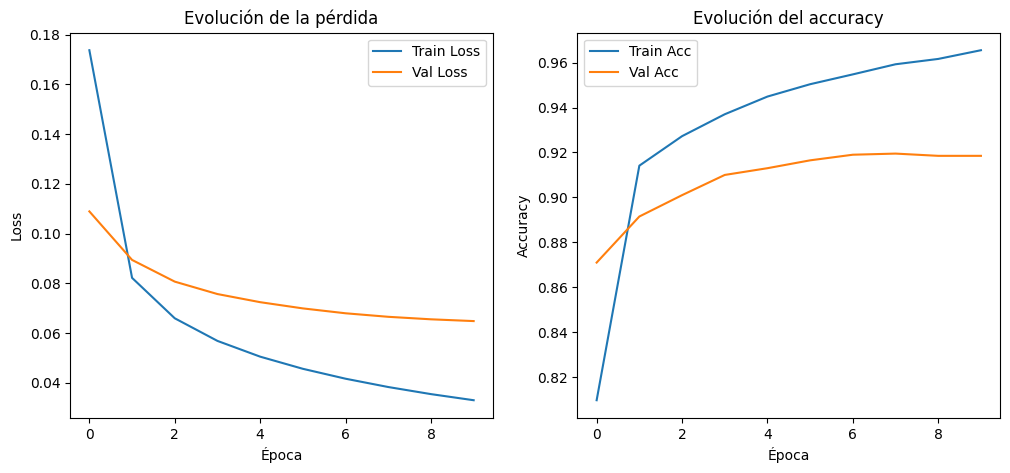

Entrenando con f(x) activación=sigmoid, capas=[32], lr=0.01
Epoch 1/10 - Loss: 0.3903 - Acc: 0.5114
Epoch 2/10 - Loss: 0.2564 - Acc: 0.7515
Epoch 3/10 - Loss: 0.1898 - Acc: 0.8379
Epoch 4/10 - Loss: 0.1536 - Acc: 0.8689
Epoch 5/10 - Loss: 0.1320 - Acc: 0.8828
Epoch 6/10 - Loss: 0.1179 - Acc: 0.8920
Epoch 7/10 - Loss: 0.1079 - Acc: 0.8984
Epoch 8/10 - Loss: 0.1004 - Acc: 0.9032
Epoch 9/10 - Loss: 0.0945 - Acc: 0.9083
Epoch 10/10 - Loss: 0.0896 - Acc: 0.9106


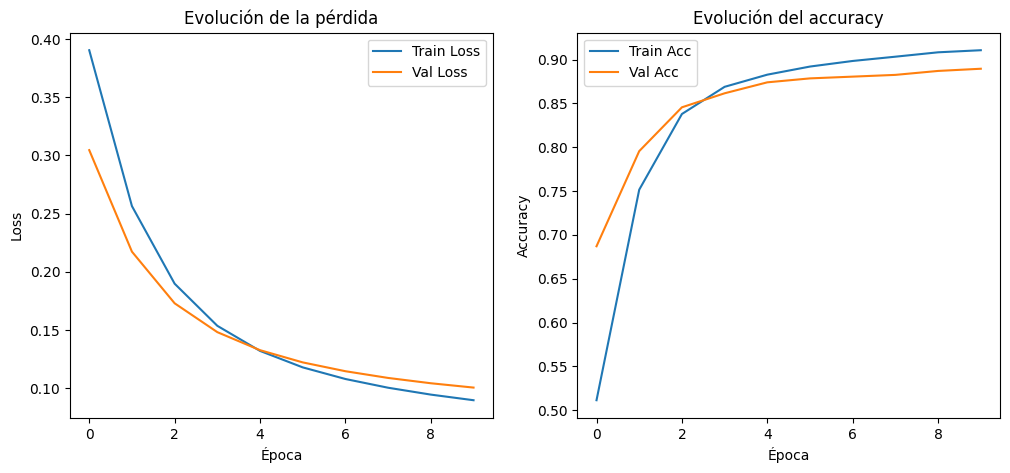

Entrenando con f(x) activación=sigmoid, capas=[32], lr=0.001
Epoch 1/10 - Loss: 0.5614 - Acc: 0.1694
Epoch 2/10 - Loss: 0.4414 - Acc: 0.3035
Epoch 3/10 - Loss: 0.4317 - Acc: 0.3624
Epoch 4/10 - Loss: 0.4208 - Acc: 0.3866
Epoch 5/10 - Loss: 0.4080 - Acc: 0.4032
Epoch 6/10 - Loss: 0.3943 - Acc: 0.4220
Epoch 7/10 - Loss: 0.3803 - Acc: 0.4477
Epoch 8/10 - Loss: 0.3668 - Acc: 0.4766
Epoch 9/10 - Loss: 0.3538 - Acc: 0.5040
Epoch 10/10 - Loss: 0.3415 - Acc: 0.5337


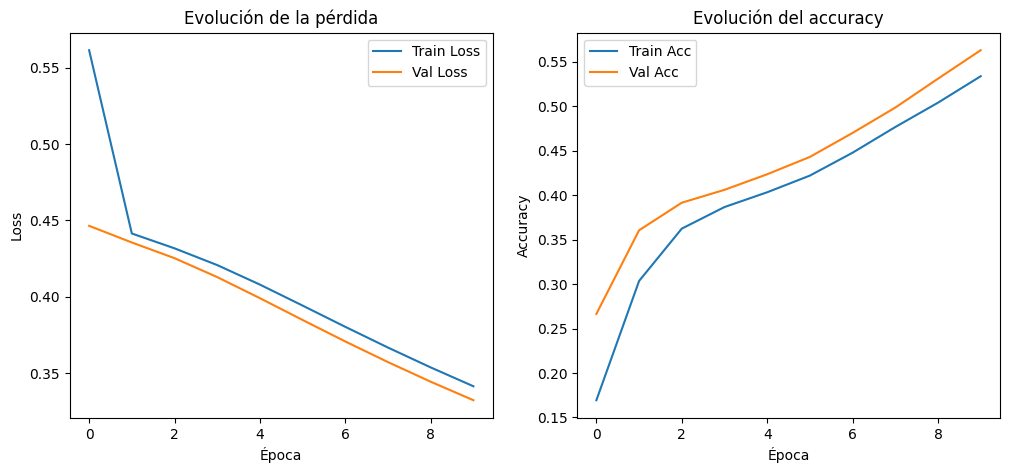

Entrenando con f(x) activación=sigmoid, capas=[64], lr=0.1
Epoch 1/10 - Loss: 0.1652 - Acc: 0.8137
Epoch 2/10 - Loss: 0.0809 - Acc: 0.9141
Epoch 3/10 - Loss: 0.0651 - Acc: 0.9297
Epoch 4/10 - Loss: 0.0559 - Acc: 0.9375
Epoch 5/10 - Loss: 0.0494 - Acc: 0.9451
Epoch 6/10 - Loss: 0.0443 - Acc: 0.9509
Epoch 7/10 - Loss: 0.0401 - Acc: 0.9565
Epoch 8/10 - Loss: 0.0366 - Acc: 0.9611
Epoch 9/10 - Loss: 0.0336 - Acc: 0.9630
Epoch 10/10 - Loss: 0.0310 - Acc: 0.9675


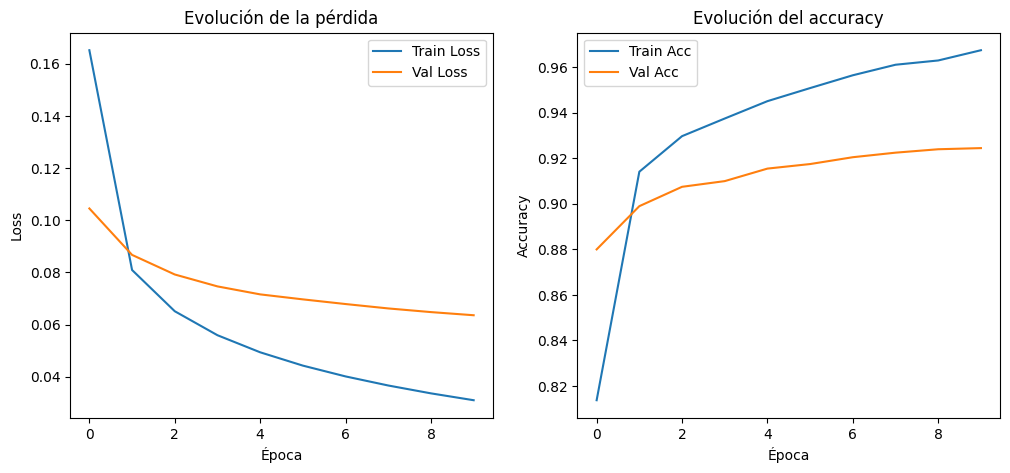

Entrenando con f(x) activación=sigmoid, capas=[64], lr=0.01
Epoch 1/10 - Loss: 0.3818 - Acc: 0.5259
Epoch 2/10 - Loss: 0.2408 - Acc: 0.7516
Epoch 3/10 - Loss: 0.1802 - Acc: 0.8375
Epoch 4/10 - Loss: 0.1468 - Acc: 0.8686
Epoch 5/10 - Loss: 0.1266 - Acc: 0.8835
Epoch 6/10 - Loss: 0.1136 - Acc: 0.8939
Epoch 7/10 - Loss: 0.1045 - Acc: 0.9004
Epoch 8/10 - Loss: 0.0978 - Acc: 0.9056
Epoch 9/10 - Loss: 0.0924 - Acc: 0.9106
Epoch 10/10 - Loss: 0.0881 - Acc: 0.9134


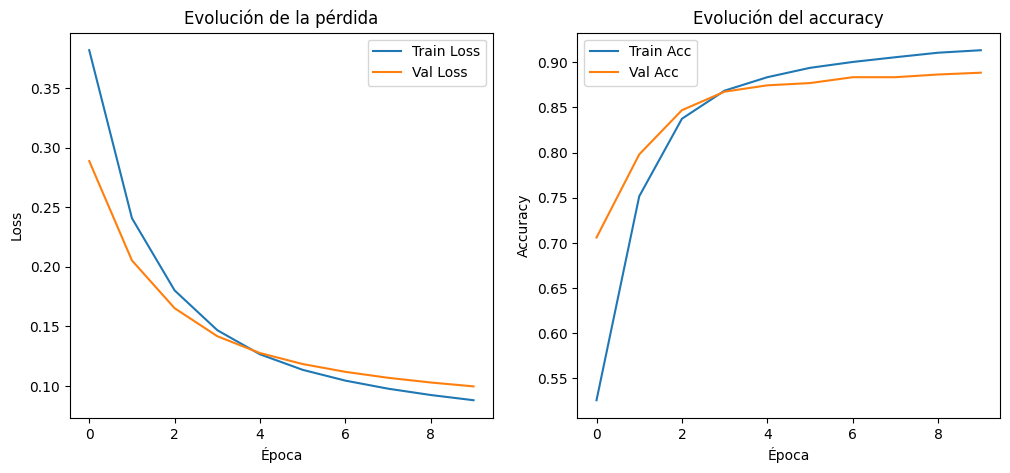

Entrenando con f(x) activación=sigmoid, capas=[64], lr=0.001
Epoch 1/10 - Loss: 0.5340 - Acc: 0.2620
Epoch 2/10 - Loss: 0.4286 - Acc: 0.3901
Epoch 3/10 - Loss: 0.4125 - Acc: 0.4479
Epoch 4/10 - Loss: 0.3938 - Acc: 0.5070
Epoch 5/10 - Loss: 0.3736 - Acc: 0.5543
Epoch 6/10 - Loss: 0.3535 - Acc: 0.5911
Epoch 7/10 - Loss: 0.3344 - Acc: 0.6259
Epoch 8/10 - Loss: 0.3167 - Acc: 0.6564
Epoch 9/10 - Loss: 0.3007 - Acc: 0.6826
Epoch 10/10 - Loss: 0.2862 - Acc: 0.7079


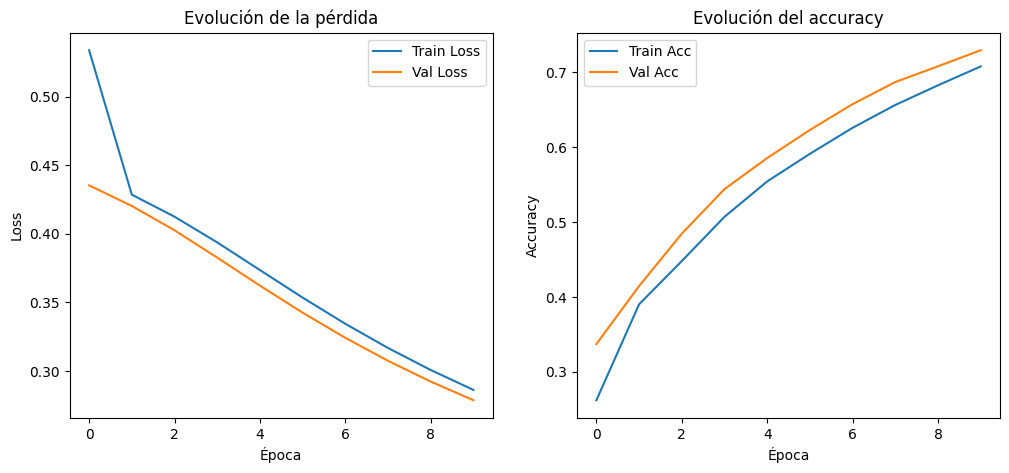

Entrenando con f(x) activación=sigmoid, capas=[128], lr=0.1
Epoch 1/10 - Loss: 0.1645 - Acc: 0.8056
Epoch 2/10 - Loss: 0.0854 - Acc: 0.9074
Epoch 3/10 - Loss: 0.0697 - Acc: 0.9243
Epoch 4/10 - Loss: 0.0599 - Acc: 0.9333
Epoch 5/10 - Loss: 0.0525 - Acc: 0.9401
Epoch 6/10 - Loss: 0.0468 - Acc: 0.9475
Epoch 7/10 - Loss: 0.0421 - Acc: 0.9523
Epoch 8/10 - Loss: 0.0383 - Acc: 0.9560
Epoch 9/10 - Loss: 0.0349 - Acc: 0.9600
Epoch 10/10 - Loss: 0.0320 - Acc: 0.9646


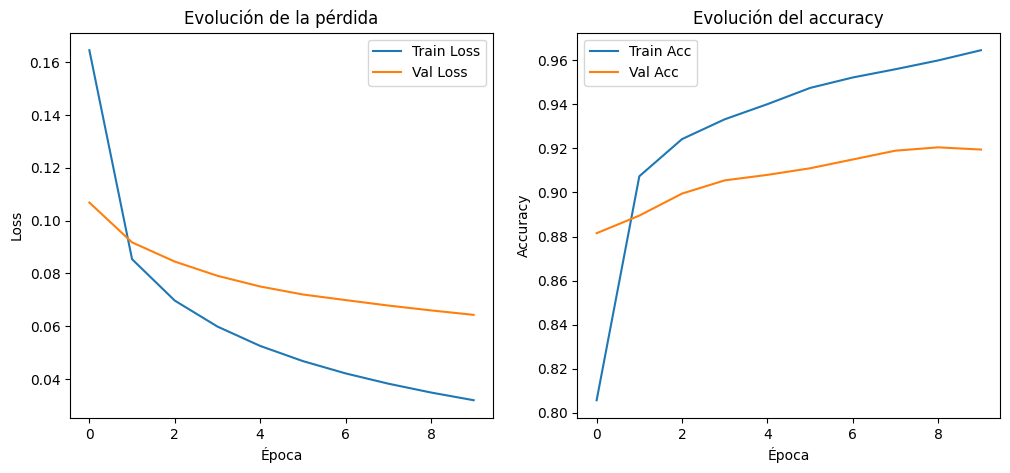

Entrenando con f(x) activación=sigmoid, capas=[128], lr=0.01
Epoch 1/10 - Loss: 0.3631 - Acc: 0.5621
Epoch 2/10 - Loss: 0.2160 - Acc: 0.8091
Epoch 3/10 - Loss: 0.1622 - Acc: 0.8585
Epoch 4/10 - Loss: 0.1360 - Acc: 0.8765
Epoch 5/10 - Loss: 0.1205 - Acc: 0.8871
Epoch 6/10 - Loss: 0.1103 - Acc: 0.8941
Epoch 7/10 - Loss: 0.1029 - Acc: 0.9000
Epoch 8/10 - Loss: 0.0973 - Acc: 0.9048
Epoch 9/10 - Loss: 0.0927 - Acc: 0.9086
Epoch 10/10 - Loss: 0.0889 - Acc: 0.9120


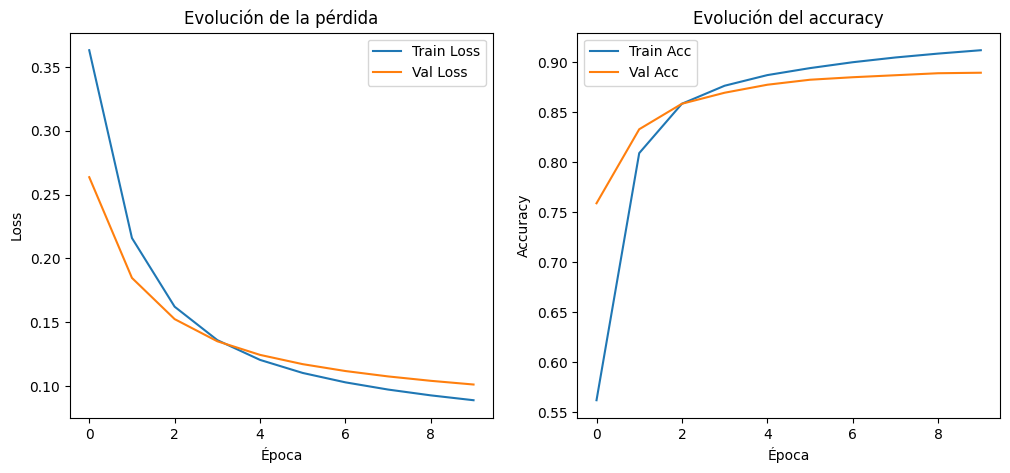

Entrenando con f(x) activación=sigmoid, capas=[128], lr=0.001
Epoch 1/10 - Loss: 0.4815 - Acc: 0.2497
Epoch 2/10 - Loss: 0.4299 - Acc: 0.4046
Epoch 3/10 - Loss: 0.4122 - Acc: 0.4474
Epoch 4/10 - Loss: 0.3906 - Acc: 0.4971
Epoch 5/10 - Loss: 0.3672 - Acc: 0.5580
Epoch 6/10 - Loss: 0.3439 - Acc: 0.6148
Epoch 7/10 - Loss: 0.3220 - Acc: 0.6644
Epoch 8/10 - Loss: 0.3021 - Acc: 0.7024
Epoch 9/10 - Loss: 0.2844 - Acc: 0.7324
Epoch 10/10 - Loss: 0.2689 - Acc: 0.7572


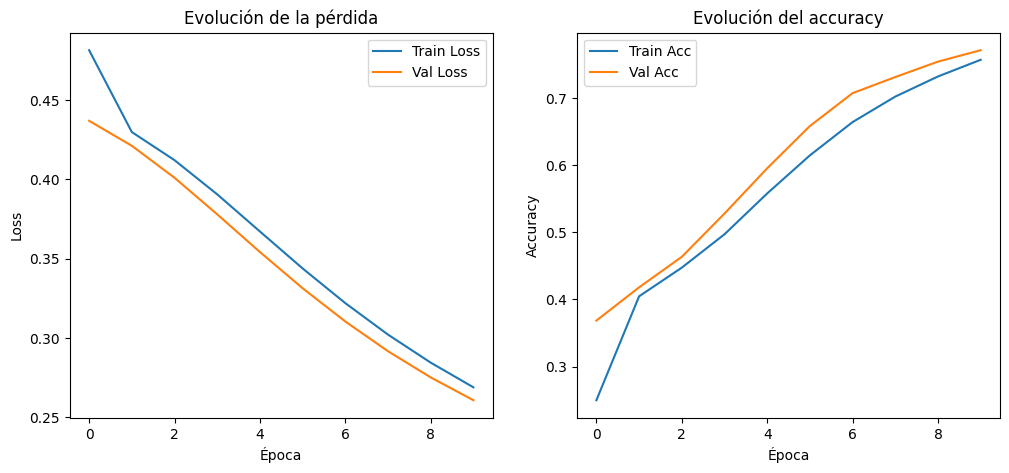

Entrenando con f(x) activación=sigmoid, capas=[64, 32], lr=0.1
Epoch 1/10 - Loss: 0.2836 - Acc: 0.5936
Epoch 2/10 - Loss: 0.1103 - Acc: 0.8832
Epoch 3/10 - Loss: 0.0735 - Acc: 0.9184
Epoch 4/10 - Loss: 0.0593 - Acc: 0.9311
Epoch 5/10 - Loss: 0.0505 - Acc: 0.9406
Epoch 6/10 - Loss: 0.0440 - Acc: 0.9503
Epoch 7/10 - Loss: 0.0390 - Acc: 0.9559
Epoch 8/10 - Loss: 0.0348 - Acc: 0.9614
Epoch 9/10 - Loss: 0.0311 - Acc: 0.9663
Epoch 10/10 - Loss: 0.0280 - Acc: 0.9699


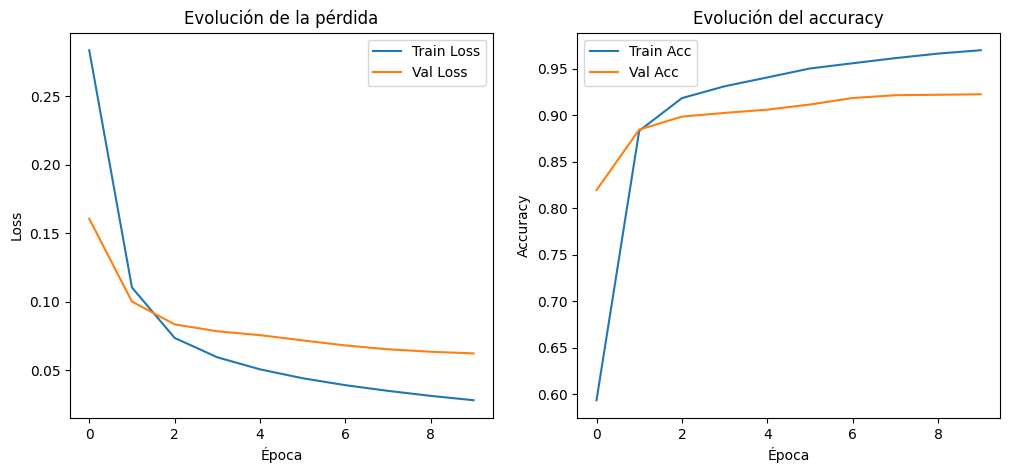

Entrenando con f(x) activación=sigmoid, capas=[64, 32], lr=0.01
Epoch 1/10 - Loss: 0.4545 - Acc: 0.1852
Epoch 2/10 - Loss: 0.4268 - Acc: 0.3731
Epoch 3/10 - Loss: 0.3785 - Acc: 0.5366
Epoch 4/10 - Loss: 0.3079 - Acc: 0.6408
Epoch 5/10 - Loss: 0.2536 - Acc: 0.7099
Epoch 6/10 - Loss: 0.2184 - Acc: 0.7561
Epoch 7/10 - Loss: 0.1929 - Acc: 0.7960
Epoch 8/10 - Loss: 0.1710 - Acc: 0.8314
Epoch 9/10 - Loss: 0.1519 - Acc: 0.8560
Epoch 10/10 - Loss: 0.1359 - Acc: 0.8748


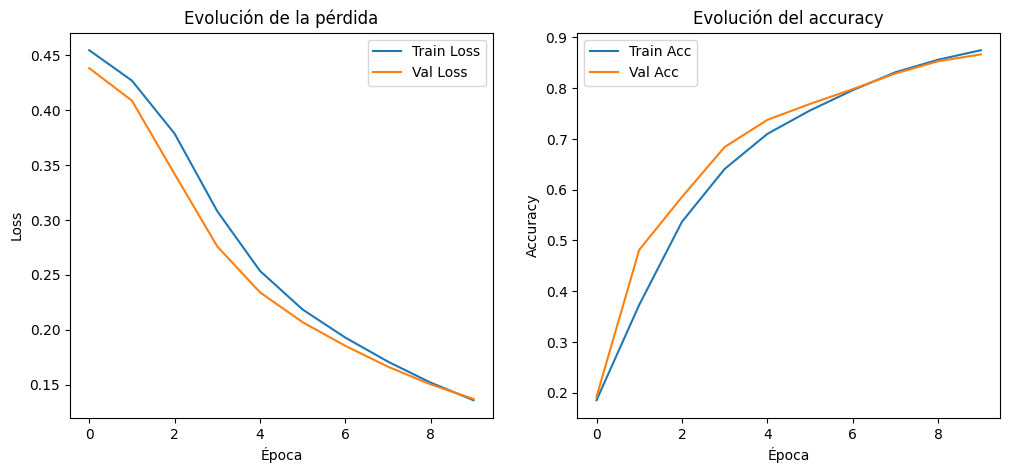

Entrenando con f(x) activación=sigmoid, capas=[64, 32], lr=0.001
Epoch 1/10 - Loss: 0.5405 - Acc: 0.1031
Epoch 2/10 - Loss: 0.4500 - Acc: 0.1219
Epoch 3/10 - Loss: 0.4483 - Acc: 0.1199
Epoch 4/10 - Loss: 0.4476 - Acc: 0.1229
Epoch 5/10 - Loss: 0.4469 - Acc: 0.1301
Epoch 6/10 - Loss: 0.4462 - Acc: 0.1414
Epoch 7/10 - Loss: 0.4455 - Acc: 0.1575
Epoch 8/10 - Loss: 0.4448 - Acc: 0.1839
Epoch 9/10 - Loss: 0.4440 - Acc: 0.2157
Epoch 10/10 - Loss: 0.4431 - Acc: 0.2537


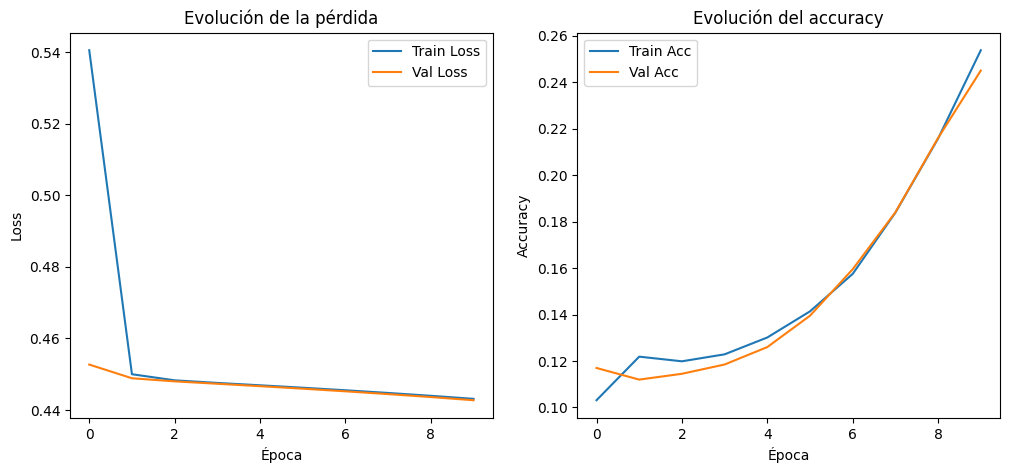

Entrenando con f(x) activación=sigmoid, capas=[32, 32, 32], lr=0.1
Epoch 1/10 - Loss: 0.4298 - Acc: 0.2135
Epoch 2/10 - Loss: 0.2417 - Acc: 0.6821
Epoch 3/10 - Loss: 0.1234 - Acc: 0.8555
Epoch 4/10 - Loss: 0.0849 - Acc: 0.9054
Epoch 5/10 - Loss: 0.0657 - Acc: 0.9240
Epoch 6/10 - Loss: 0.0557 - Acc: 0.9345
Epoch 7/10 - Loss: 0.0481 - Acc: 0.9416


In [ ]:
output_layer_size = 10  # MNIST tiene 10 clases
resultados = []
for act in activaciones:
    for capa in capas:
        for lr in learning_rates:
            nn = NeuralNetwork([X_train.shape[1], *capa, output_layer_size], learning_rate=lr, activation=act)
            print(f"Entrenando con f(x) activación={act}, capas={capa}, lr={lr}")
            hist = nn.train(X_train, y_train, epochs=epoch, X_val=X_val, Y_val=y_val)
            resultados.append({
                'activacion': act,
                'capas': str(capa),
                'lr': lr,
                'val_acc': max(hist['val_accuracy']),
                'val_loss': min(hist['val_loss'])
            })
            # Graficar para cada experimento
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["loss"], label="Train Loss")
            plt.plot(hist["val_loss"], label="Val Loss")
            plt.xlabel("Época")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("Evolución de la pérdida")

            plt.subplot(1, 2, 2)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["accuracy"], label="Train Acc")
            plt.plot(hist["val_accuracy"], label="Val Acc")
            plt.xlabel("Época")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.title("Evolución del accuracy")
            plt.show()

# Tabla resumen
pd.DataFrame(resultados).sort_values('val_acc', ascending=False)

### Prueba de dataset CIFAR-10

In [ ]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar10(f"data/CIFAR-10")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y

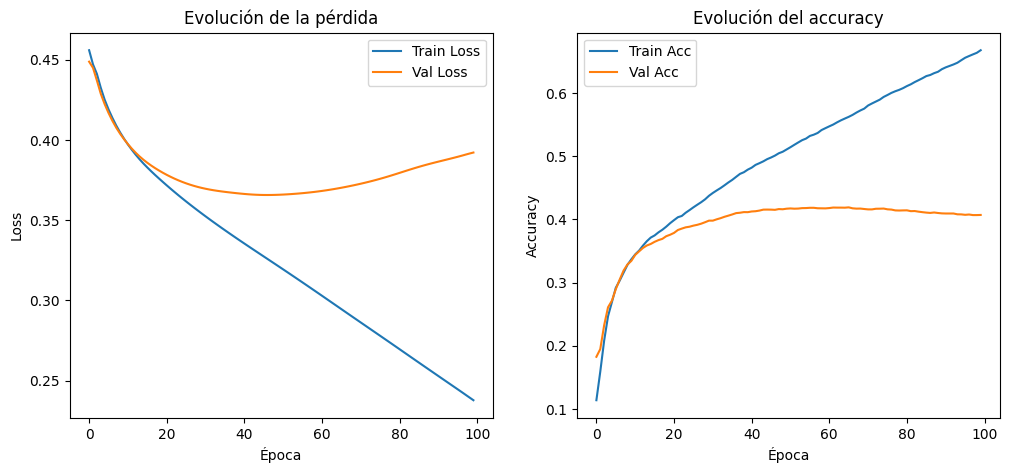

In [ ]:
output_layer_size = 10  # CIFAR-10 tiene 10 clases
resultados = []
for act in activaciones:
    for capa in capas:
        for lr in learning_rates:
            nn = NeuralNetwork([X_train.shape[1], *capa, output_layer_size], learning_rate=lr, activation=act)
            print(f"Entrenando con f(x) activación={act}, capas={capa}, lr={lr}")
            hist = nn.train(X_train, y_train, epochs=epoch, X_val=X_val, Y_val=y_val)
            resultados.append({
                'activacion': act,
                'capas': str(capa),
                'lr': lr,
                'val_acc': max(hist['val_accuracy']),
                'val_loss': min(hist['val_loss'])
            })
            # Graficar para cada experimento
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["loss"], label="Train Loss")
            plt.plot(hist["val_loss"], label="Val Loss")
            plt.xlabel("Época")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("Evolución de la pérdida")

            plt.subplot(1, 2, 2)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["accuracy"], label="Train Acc")
            plt.plot(hist["val_accuracy"], label="Val Acc")
            plt.xlabel("Época")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.title("Evolución del accuracy")
            plt.show()

# Tabla resumen
pd.DataFrame(resultados).sort_values('val_acc', ascending=False)

### Prueba de dataset CIFAR-100

In [ ]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar100(f"data/CIFAR-100")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y


Pesos de la capa de salida:
Neurona 0: [-0.20724945  0.41571839 -0.14944219 -0.05757601  0.23028171  0.3499999
  0.2173457  -0.29496126  0.31837704 -0.14314703 -0.37406133  0.09828584
 -0.36073573 -0.03023553  0.37231128  0.41160858  0.20882544  0.16963291
  0.31628233 -0.08188984  0.1032163   0.20488514  0.27093572 -0.01134825
  0.04688016 -0.39794204  0.05163963 -0.2583686  -0.05009854  0.07747291
  0.30419156  0.08937501]
Neurona 1: [-0.17903534  0.01336629 -0.39445242  0.09661577  0.24712928  0.17731751
 -0.00119742 -0.27940745 -0.093417    0.24336327  0.10469396 -0.19112562
  0.20902821  0.17996798 -0.36907948 -0.38769876  0.1148671   0.11281279
  0.04804068  0.00226606  0.25564076 -0.32926692 -0.07769252 -0.21715777
 -0.0459294  -0.04021083 -0.07234684 -0.39593386  0.32228857 -0.2415774
 -0.12269152  0.31450491]
Neurona 2: [ 0.12077529 -0.14681541 -0.35699868 -0.15699562  0.0541082   0.26331047
 -0.42108065  0.24310047 -0.2784732   0.11839823 -0.01410105  0.27501351
 -0.27904218

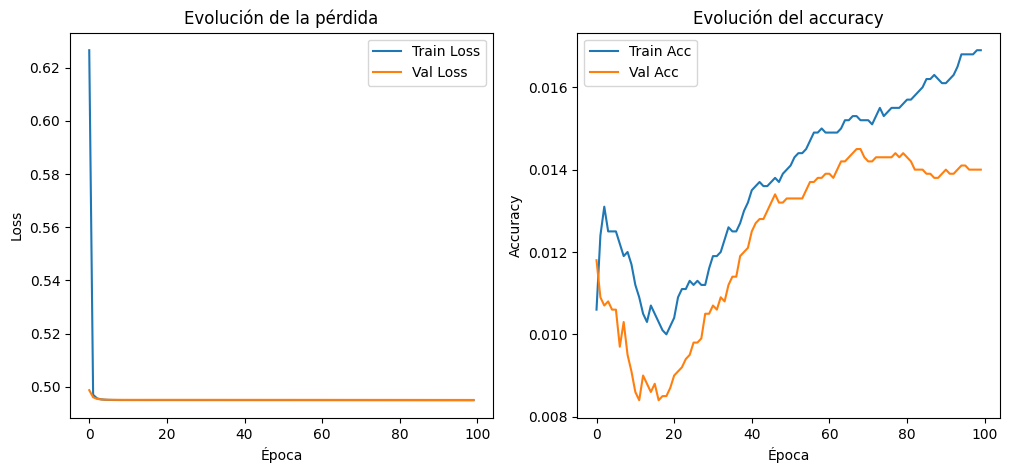

In [ ]:
output_layer_size = 100  # CIFAR-100 tiene 100 clases
resultados = []
for act in activaciones:
    for capa in capas:
        for lr in learning_rates:
            nn = NeuralNetwork([X_train.shape[1], *capa, output_layer_size], learning_rate=lr, activation=act)
            print(f"Entrenando con f(x) activación={act}, capas={capa}, lr={lr}")
            hist = nn.train(X_train, y_train, epochs=epoch, X_val=X_val, Y_val=y_val)
            resultados.append({
                'activacion': act,
                'capas': str(capa),
                'lr': lr,
                'val_acc': max(hist['val_accuracy']),
                'val_loss': min(hist['val_loss'])
            })
            # Graficar para cada experimento
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["loss"], label="Train Loss")
            plt.plot(hist["val_loss"], label="Val Loss")
            plt.xlabel("Época")
            plt.ylabel("Loss")
            plt.legend()
            plt.title("Evolución de la pérdida")

            plt.subplot(1, 2, 2)
            plt.title(f"Numpy: {act}, capas={capa}, lr={lr}")
            plt.plot(hist["accuracy"], label="Train Acc")
            plt.plot(hist["val_accuracy"], label="Val Acc")
            plt.xlabel("Época")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.title("Evolución del accuracy")
            plt.show()

# Tabla resumen
pd.DataFrame(resultados).sort_values('val_acc', ascending=False)

# Implementación con Pytorch

### Implementación

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [27]:
class NeuralNetworkPyTorch:
    def __init__(self, layer_sizes, learning_rate=0.01, device=None):
        """
        layer_sizes: lista con tamaño de capas, e.g., [3072, 64, 32, 100]
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.build_model(layer_sizes).to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
    
    def build_model(self, sizes):
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            layers.append(nn.Sigmoid())  # Usamos Sigmoid para imitar tu perceptrón
        # Capa final (sin Sigmoid, CrossEntropy incluye softmax internamente)
        layers.append(nn.Linear(sizes[-2], sizes[-1]))
        return nn.Sequential(*layers)

    def train(self, X, Y, epochs=10, batch_size=64, X_val=None, Y_val=None):
        """
        X: tensor (n_samples x input_dim)
        Y: tensor de etiquetas (n_samples,) tipo long (no one-hot)
        """
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
        dataset = torch.utils.data.TensorDataset(X, Y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            for batch_X, batch_Y in loader:
                batch_X = batch_X.to(self.device)
                batch_Y = batch_Y.to(self.device)

                outputs = self.model(batch_X)
                loss = self.loss_fn(outputs, batch_Y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == batch_Y).sum().item()
                total += batch_Y.size(0)
            
            avg_loss = total_loss / len(loader)
            acc = correct / total
            history['loss'].append(avg_loss)
            history['accuracy'].append(acc)

            # Evaluación en validación si se pasa
            if X_val is not None and Y_val is not None:
                self.model.eval()
                with torch.no_grad():
                    X_val = X_val.to(self.device)
                    Y_val = Y_val.to(self.device)
                    outputs = self.model(X_val)
                    val_loss = self.loss_fn(outputs, Y_val).item()
                    _, predicted = torch.max(outputs, 1)
                    val_acc = (predicted == Y_val).sum().item() / Y_val.size(0)
                    history['val_loss'].append(val_loss)
                    history['val_accuracy'].append(val_acc)

            # Mostrar progreso cada 10% del total
            if epoch % max(1, epochs // 10) == 0:
                log = f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Acc: {acc:.4f}"
                if X_val is not None and Y_val is not None:
                    log += f" - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}"
                print(log)

        return history

    def predict(self, X):
        """
        X: tensor (n_samples x input_dim)
        return: tensor con índices de clases predichas
        """
        self.model.eval()
        with torch.no_grad():
            X = X.to(self.device)
            outputs = self.model(X)
            predictions = torch.argmax(outputs, dim=1)
        return predictions

In [ ]:
activaciones = ['sigmoid', 'linear']
capas = [[32], [64], [128], [64, 32], [32, 32, 32]]
learning_rates = [0.1, 0.01, 0.001]
epoch = 10

### Prueba con dataset MNIST

In [ ]:
# https://www.kaggle.com/code/annisin/classification-task
# Imagenes blanco y negro
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Split dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = x_train.reshape((x_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

# 2. Hacemos un split 80/20 sobre ese subconjunto
split = int(0.8 * n_samples)
X_train = X[:split]
y_train = Y[:split]
X_test = X[split:]
y_test = Y[split:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

In [ ]:
output_layer_size = 10
pt_grid = {
    "hidden_sizes": capas,
    "learning_rates": learning_rates,
    "activations": activaciones,
}
pt_results = []

for hs, lr, act in itertools.product(
    pt_grid["hidden_sizes"], pt_grid["learning_rates"], pt_grid["activations"]
):
    model = NeuralNetworkPyTorch(
        [X_train.shape[1], *hs, output_layer_size], learning_rate=lr, activation=act
    )
    h = model.train(
        X_train_tensor,
        y_train_tensor,
        epochs=epoch,
        X_val=X_test_tensor,
        Y_val=y_test_tensor,
    )
    pt_results.append(
        {
            "hidden": str(hs),
            "learning_rate": lr,
            "act": act,
            "val_acc": max(h["val_accuracy"]),
            "val_loss": min(h["val_loss"]),
        }
    )
    # Graficar para cada experimento
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["loss"], label="Train Loss")
    plt.plot(h["val_loss"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Evolución de la pérdida")

    plt.subplot(1, 2, 2)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["accuracy"], label="Train Acc")
    plt.plot(h["val_accuracy"], label="Val Acc")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Evolución del accuracy")
    plt.show()


# Tabla resumen
pd.DataFrame(pt_results).sort_values("val_acc", ascending=False)

Epoch 1/100 - Loss: 2.2941 - Acc: 0.1390 - Val Loss: 2.2674 - Val Acc: 0.3205
Epoch 11/100 - Loss: 1.7153 - Acc: 0.6260 - Val Loss: 1.6738 - Val Acc: 0.6550
Epoch 21/100 - Loss: 1.0634 - Acc: 0.7792 - Val Loss: 1.0552 - Val Acc: 0.7810
Epoch 31/100 - Loss: 0.7630 - Acc: 0.8367 - Val Loss: 0.7799 - Val Acc: 0.8305
Epoch 41/100 - Loss: 0.6102 - Acc: 0.8649 - Val Loss: 0.6431 - Val Acc: 0.8595
Epoch 51/100 - Loss: 0.5198 - Acc: 0.8778 - Val Loss: 0.5619 - Val Acc: 0.8680
Epoch 61/100 - Loss: 0.4606 - Acc: 0.8889 - Val Loss: 0.5092 - Val Acc: 0.8755
Epoch 71/100 - Loss: 0.4192 - Acc: 0.8965 - Val Loss: 0.4745 - Val Acc: 0.8790
Epoch 81/100 - Loss: 0.3886 - Acc: 0.9028 - Val Loss: 0.4478 - Val Acc: 0.8820
Epoch 91/100 - Loss: 0.3650 - Acc: 0.9061 - Val Loss: 0.4284 - Val Acc: 0.8840


### Prueba con dataset CIFAR-10

In [ ]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar10(f"data/CIFAR-10")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)  # epochs puede ajustarse

Epoch 1/100 - Loss: 2.3226 - Acc: 0.1026 - Val Loss: 2.3062 - Val Acc: 0.1000
Epoch 11/100 - Loss: 2.2915 - Acc: 0.1659 - Val Loss: 2.2916 - Val Acc: 0.1587
Epoch 21/100 - Loss: 2.2612 - Acc: 0.1929 - Val Loss: 2.2607 - Val Acc: 0.1769
Epoch 31/100 - Loss: 2.1764 - Acc: 0.1871 - Val Loss: 2.1774 - Val Acc: 0.1759
Epoch 41/100 - Loss: 2.1049 - Acc: 0.2084 - Val Loss: 2.1095 - Val Acc: 0.2010
Epoch 51/100 - Loss: 2.0667 - Acc: 0.2219 - Val Loss: 2.0715 - Val Acc: 0.2154
Epoch 61/100 - Loss: 2.0408 - Acc: 0.2387 - Val Loss: 2.0478 - Val Acc: 0.2218
Epoch 71/100 - Loss: 2.0157 - Acc: 0.2514 - Val Loss: 2.0220 - Val Acc: 0.2443
Epoch 81/100 - Loss: 1.9842 - Acc: 0.2651 - Val Loss: 1.9924 - Val Acc: 0.2562
Epoch 91/100 - Loss: 1.9538 - Acc: 0.2797 - Val Loss: 1.9628 - Val Acc: 0.2706


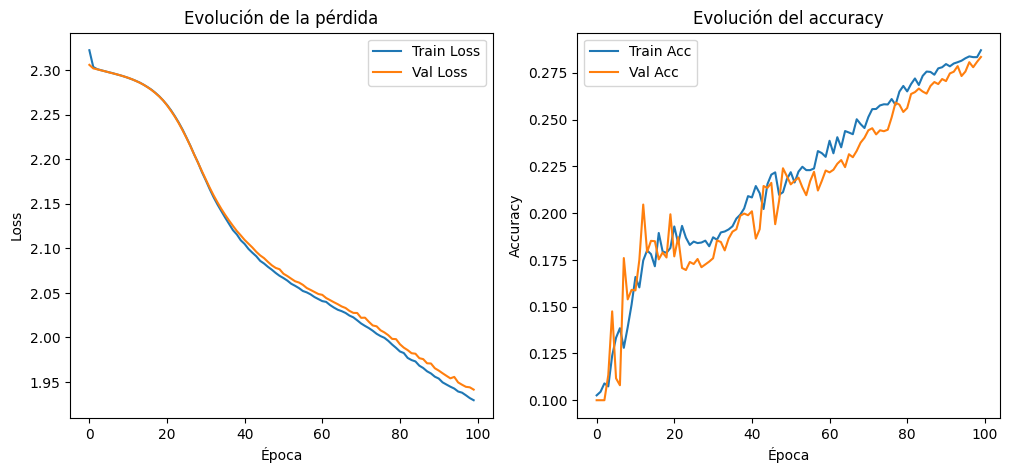

In [ ]:
output_layer_size = 10
pt_grid = {
    "hidden_sizes": capas,
    "learning_rates": learning_rates,
    "activations": activaciones,
}
pt_results = []

for hs, lr, act in itertools.product(
    pt_grid["hidden_sizes"], pt_grid["learning_rates"], pt_grid["activations"]
):
    model = NeuralNetworkPyTorch(
        [X_train.shape[1], *hs, output_layer_size], learning_rate=lr, activation=act
    )
    h = model.train(
        X_train_tensor,
        y_train_tensor,
        epochs=epoch,
        X_val=X_test_tensor,
        Y_val=y_test_tensor,
    )
    pt_results.append(
        {
            "hidden": str(hs),
            "learning_rate": lr,
            "act": act,
            "val_acc": max(h["val_accuracy"]),
            "val_loss": min(h["val_loss"]),
        }
    )
    # Graficar para cada experimento
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["loss"], label="Train Loss")
    plt.plot(h["val_loss"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Evolución de la pérdida")

    plt.subplot(1, 2, 2)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["accuracy"], label="Train Acc")
    plt.plot(h["val_accuracy"], label="Val Acc")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Evolución del accuracy")
    plt.show()


# Tabla resumen
pd.DataFrame(pt_results).sort_values("val_acc", ascending=False)

In [ ]:
# Cargamos los datos
X_train, y_train, X_test, y_test = load_cifar100(f"data/CIFAR-100")

# Aplanamos las imágenes (de 32x32x3 a 3072)
X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

# 1. Seleccionamos un porcentaje del total (por ejemplo, 200 muestras)
n_samples = 10000  # Cambia este valor para usar más o menos datos
X = X_train.reshape((X_train.shape[0], -1))[:n_samples]
Y = y_train[:n_samples]

X_train = X
y_train = Y

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)  # epochs puede ajustarse

Epoch 1/100 - Loss: 4.6415 - Acc: 0.0113 - Val Loss: 4.6400 - Val Acc: 0.0101
Epoch 11/100 - Loss: 4.6014 - Acc: 0.0121 - Val Loss: 4.6102 - Val Acc: 0.0100
Epoch 21/100 - Loss: 4.5979 - Acc: 0.0133 - Val Loss: 4.6080 - Val Acc: 0.0123
Epoch 31/100 - Loss: 4.5963 - Acc: 0.0145 - Val Loss: 4.6067 - Val Acc: 0.0129
Epoch 41/100 - Loss: 4.5941 - Acc: 0.0173 - Val Loss: 4.6048 - Val Acc: 0.0137
Epoch 51/100 - Loss: 4.5910 - Acc: 0.0175 - Val Loss: 4.6021 - Val Acc: 0.0139
Epoch 61/100 - Loss: 4.5870 - Acc: 0.0204 - Val Loss: 4.5978 - Val Acc: 0.0170
Epoch 71/100 - Loss: 4.5798 - Acc: 0.0263 - Val Loss: 4.5910 - Val Acc: 0.0197
Epoch 81/100 - Loss: 4.5682 - Acc: 0.0253 - Val Loss: 4.5796 - Val Acc: 0.0200
Epoch 91/100 - Loss: 4.5492 - Acc: 0.0271 - Val Loss: 4.5612 - Val Acc: 0.0263


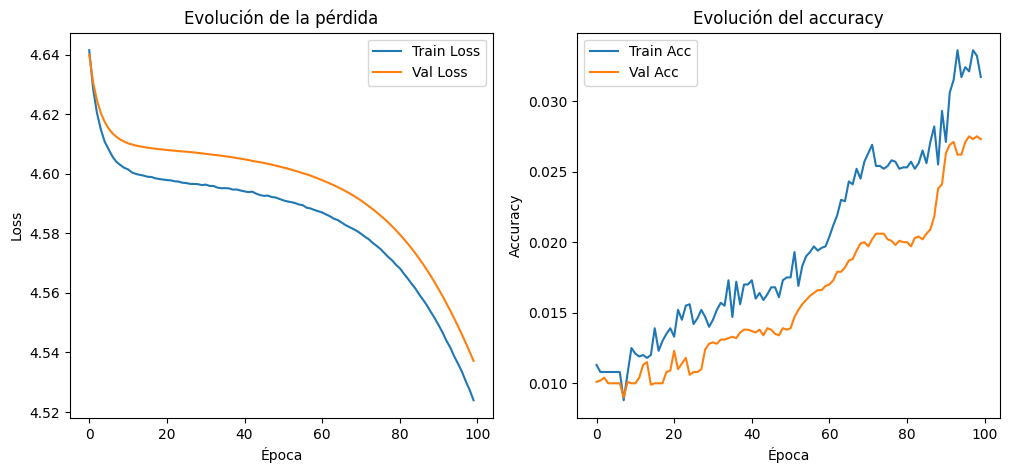

In [ ]:
output_layer_size = 100
pt_grid = {
    "hidden_sizes": capas,
    "learning_rates": learning_rates,
    "activations": activaciones,
}
pt_results = []

for hs, lr, act in itertools.product(
    pt_grid["hidden_sizes"], pt_grid["learning_rates"], pt_grid["activations"]
):
    model = NeuralNetworkPyTorch(
        [X_train.shape[1], *hs, output_layer_size], learning_rate=lr, activation=act
    )
    h = model.train(
        X_train_tensor,
        y_train_tensor,
        epochs=epoch,
        X_val=X_test_tensor,
        Y_val=y_test_tensor,
    )
    pt_results.append(
        {
            "hidden": str(hs),
            "learning_rate": lr,
            "act": act,
            "val_acc": max(h["val_accuracy"]),
            "val_loss": min(h["val_loss"]),
        }
    )
    # Graficar para cada experimento
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["loss"], label="Train Loss")
    plt.plot(h["val_loss"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Evolución de la pérdida")

    plt.subplot(1, 2, 2)
    plt.title(f"PyTorch: {act}, capas={hs}, learning_rate={lr}")
    plt.plot(h["accuracy"], label="Train Acc")
    plt.plot(h["val_accuracy"], label="Val Acc")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Evolución del accuracy")
    plt.show()


# Tabla resumen
pd.DataFrame(pt_results).sort_values("val_acc", ascending=False)